# Introduction

## Overview of the Problem

Satellite plane detection is a critical task in various applications such as surveillance, environmental monitoring, and spatial mapping. The ability to accurately identify satellite planes from images can greatly enhance the efficiency and accuracy of satellite data interpretation, which is crucial for decision-making processess.

## Objective of the Project

The primary goal of this project is to develop a robust model that can detect satellite planes with high accuracy while minimizing false positives. By leveraging the power of Convolutional Neural Networks (CNNs), this project aims to refine image-based detection techniques to achieve superior performance in recognizing satellite planes from complex backgrounds and under varying conditions.

## Brief Overview of CNNs

Convolutional Neural Networks (CNNs) are a category of deep neural networks that are particularly powerful for tasks involving image recognition and classification. CNNs are designed to automatically and adaptively learn spatial hierarchies of features through backpropagation. This capability makes them exceptionally suitable for computer vision tasks, including the detection of objects within larger images, such as satellite planes in satellite imagery. The use of CNNs in this project is predicated on their success in similar applications, where they have consistently outperformed traditional machine learning approaches.


In [17]:
import cv2
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.patches as patches


## Image Preprocessing

Preprocessing the images is a critical step to ensure that our Convolutional Neural Network (CNN) can effectively learn from the data. The preprocessing steps performed include:

1. **Reading the Images**: We start by looping over each png file in the specified directory. Each image represents a satellite photograph that may or may not contain a plane.

2. **Color Conversion**: By default, OpenCV reads images in BGR format. However, our CNN will perform better if the images are in RGB format.

3. **Normalization**: To facilitate faster convergence during training, we normalize the pixel values of each image.

Each preprocessed image is stored in a list, which will later be converted into a numpy array for numerical computation. This array forms the input to our CNN, enabling it to learn to distinguish between images with and without satellite planes.


In [19]:
basepath = "./data/planesnet/planesnet/"

images = []
labels = []

image_paths = glob(os.path.join(basepath, "*.png"))

for img_path in image_paths:
    img = cv2.imread(img_path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = img / 255.0
    
    images.append(img)
    
    label = int(os.path.basename(img_path)[0])
    labels.append(label)

images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int64)  

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

y_train = to_categorical(y_train, num_classes=2)
y_validation = to_categorical(y_validation, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_validation.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")


Training set: 22400 images
Validation set: 6432 images
Test set: 3168 images


## Neural Network Architecture

The architecture of the CNN is composed of multiple convolutional layers followed by dense layers, each serving specific purposes in the image classification task:

### Convolutional Layers
- **Feature Extraction**: The network starts with several convolutional layers (Conv2D). These layers are responsible for extracting a hierarchy of features from the input images. The first layer captures basic patterns such as edges and textures. The other layers combine these initial features into more complex structures, such as parts of planes or entire objects within the satellite images.
- **Spatial Hierarchy and Local Connectivity**: Each convolutional layer processes part of the image using filters, maintaining spatial hierarchies and capturing local feature interactions. This approach allows the model to recognize patterns efficiently across different parts of the image.

### Activation Layers (LeakyReLU)
- **Non-linearity**: We use LeakyReLU activations to introduce non-linearity into the network, allowing it to learn more complex decision boundaries.

### Pooling Layers
- **Dimensionality Reduction**: MaxPooling layers reduce the dimensionality of the feature maps, decreasing the computational load and the number of parameters. This also helps in making the detection features more robust to variations in the image, such as changes in scale and orientation.

### Dropout and Batch Normalization
- **Regularization and Normalization**: Dropout layers randomly deactivate certain neurons during training, helping to prevent overfitting by ensuring that the network remains generalizable. Batch normalization layers normalize the outputs of previous layers, speeding up training and contributing to overall network stability.

### Dense Layers
- **Classification**: After feature extraction and flattening, the network transitions to dense layers, which synthesize the features extracted by convolutional layers to make final predictions. These fully connected layers integrate learned features, leading to effective classification.
- **Output Layer**: The final dense layer uses a softmax activation function to output probabilities for each class (plane or no plane), providing the basis for our classification decision.

In [20]:
model = Sequential()
n_classes = 2

model.add(Conv2D(32, (3, 3), activation='linear', input_shape = (20, 20, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation='softmax'))

C:\Users\JT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\JT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## Model Configuration and Training

To prepare the model for detecting satellite planes, I set up a detailed training configuration, which includes compiling the model, setting checkpoints, and initiating the training process. Here’s how each component contributes to the model's training:

### Model Compilation
- **Loss Function**: We use binary_crossentropy for our loss function, which is ideal for binary classification tasks.
- **Optimizer**: The adam optimizer is chosen for its efficiency in handling sparse gradients and its adaptive learning rate capabilities.

### Checkpoints
- **ModelCheckpoint**: To ensure the best version of the model is captured during training, we implement a checkpoint strategy. This saves the model weights to a file ('plane_detection.keras') only when there is an improvement in validation accuracy (val_accuracy), which helps in avoiding overfitting and losing a potentially good model during the training process.

### Model Training
- **Training Execution**: The model is trained using the`model.fit() function, where I specify:
  - **Batch Size**: Set to 16.
  - **Epochs**: Training the model for 40 epochs.
  - **Validation Data**: The model's performance is regularly evaluated against a separate validation dataset, which helps in monitoring for overfitting.
  - **Callbacks**: The checkpoint strategy is included in the callbacks to ensure the model is saved based on the performance on the validation dataset.


In [21]:
# Compile and fit the NN 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint("plane_detection.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, y_train, batch_size=16, epochs=40, verbose=1, validation_data=(X_validation, y_validation), callbacks=[checkpoint])

Epoch 1/40
1394/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7857 - loss: 0.4695
Epoch 1: val_accuracy improved from -inf to 0.84235, saving model to plane_detection.keras
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7860 - loss: 0.4689 - val_accuracy: 0.8424 - val_loss: 0.3328
Epoch 2/40
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9051 - loss: 0.2350
Epoch 2: val_accuracy improved from 0.84235 to 0.93081, saving model to plane_detection.keras
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9051 - loss: 0.2350 - val_accuracy: 0.9308 - val_loss: 0.1628
Epoch 3/40
1395/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9250 - loss: 0.1870
Epoch 3: val_accuracy did not improve from 0.93081
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9250 - loss: 0.1870 - val_accuracy: 0.9154 - val_loss: 0.1926
Epoch 4/40
1398/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9382 - loss: 0.1607
Epoch 4: val_accuracy improved from 0.93081 to 0.949

# 5 - Evaluate the model

In [22]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9861 - loss: 0.0320
Test Loss: 0.03516494110226631
Test Accuracy: 0.9876893758773804


# 6 - Show accuracy and loss plots of the model

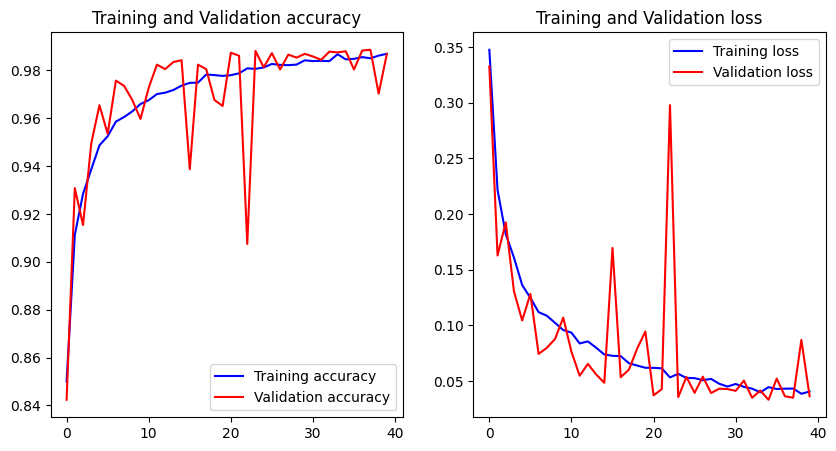

In [23]:
# Show accuracy and loss plots of the model 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# 7 - Predict

In [24]:
# Obtain predictions
predicted_class = model.predict(X_test)
print(predicted_class.shape)
print(y_test.shape)
predicted_class_probability = np.max(predicted_class, axis=1)*100
predicted_class = np.argmax(predicted_class, axis=1)
true_class = np.argmax(y_test, axis=1)

correct = []
incorrect = []

for i in range(len(predicted_class)):
    if predicted_class[i] == true_class[i]:
        correct.append(i)
    else:
        incorrect.append(i)

print('Correct predictions: ', len(correct))        
print('Incorrect predictions: ', len(incorrect))  

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(3168, 2)
(3168, 2)
Correct predictions:  3129
Incorrect predictions:  39


# 8 - Show CORRECT predictions

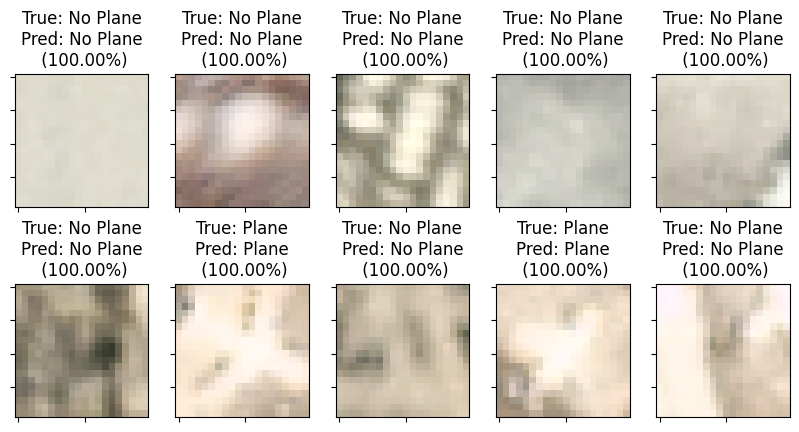

In [25]:
random.shuffle(correct)
random.shuffle(incorrect)
text_labels = ['No Plane', 'Plane']

# Show some CORRECT PREDICTIONS
n_rows = 2
n_cols = 5

plt.figure(figsize=(10, 5))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(X_test[correct[i]], cmap=plt.get_cmap('gray'))
    plt.title('True: ' + str(text_labels[true_class[correct[i]]]) + 
              '\nPred: ' + str(text_labels[predicted_class[correct[i]]]) +
              '\n' + " (%.2f%%)" % predicted_class_probability[correct[i]])

# 9 - Show INCORRECT predictions

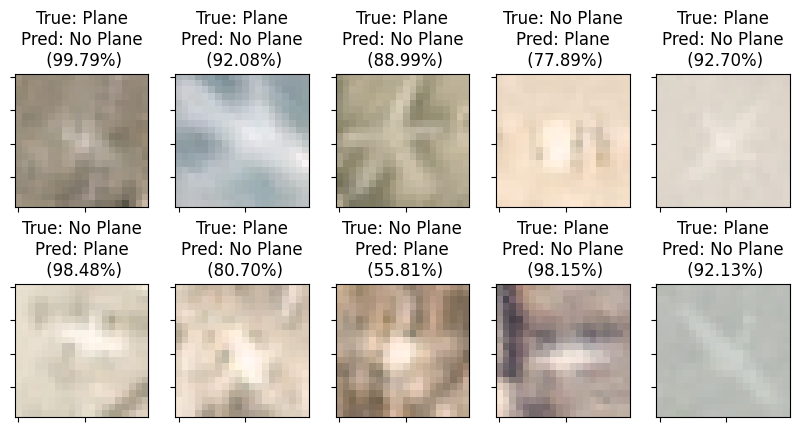

In [26]:
# Show some INCORRECT PREDICTIONS
n_rows = 2
n_cols = 5

plt.figure(figsize=(10, 5))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(X_test[incorrect[i]], cmap=plt.get_cmap('gray'))
    plt.title('True: ' + str(text_labels[true_class[incorrect[i]]]) + 
              '\nPred: ' + str(text_labels[predicted_class[incorrect[i]]]) +
              '\n' + " (%.2f%%)" % predicted_class_probability[incorrect[i]])

# 10 - Show Confussion Matrix

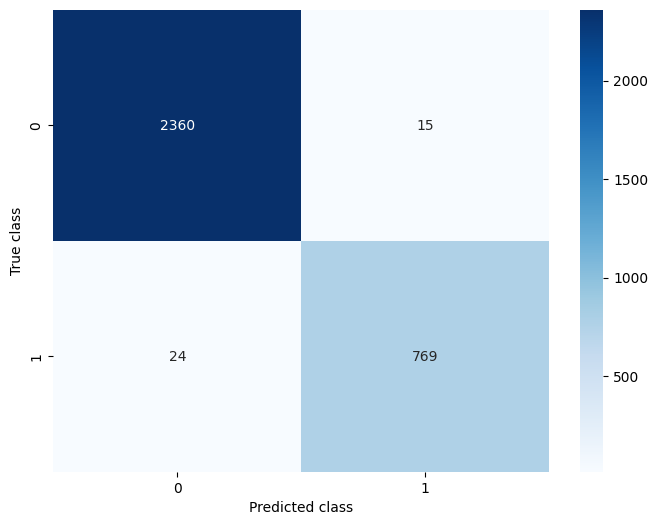

In [27]:
# Show confussion Matrix
cm = confusion_matrix(true_class, predicted_class)
plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

# 11 - Identify planes on scene

Step 0 of 52
Step 1 of 52
Step 2 of 52
Step 3 of 52
Step 4 of 52
Step 5 of 52
Step 6 of 52
Step 7 of 52
Step 8 of 52
Step 9 of 52
Step 10 of 52
Step 11 of 52
Step 12 of 52
Step 13 of 52
Step 14 of 52
Step 15 of 52
Step 16 of 52
Step 17 of 52
Step 18 of 52
Step 19 of 52
Step 20 of 52
Step 21 of 52
Step 22 of 52
Step 23 of 52
Step 24 of 52
Step 25 of 52
Step 26 of 52
Step 27 of 52
Step 28 of 52
Step 29 of 52
Step 30 of 52
Step 31 of 52
Step 32 of 52
Step 33 of 52
Step 34 of 52
Step 35 of 52
Step 36 of 52
Step 37 of 52
Step 38 of 52
Step 39 of 52
Step 40 of 52
Step 41 of 52
Step 42 of 52
Step 43 of 52
Step 44 of 52
Step 45 of 52
Step 46 of 52
Step 47 of 52
Step 48 of 52
Step 49 of 52
Step 50 of 52
Step 51 of 52
Step 52 of 52


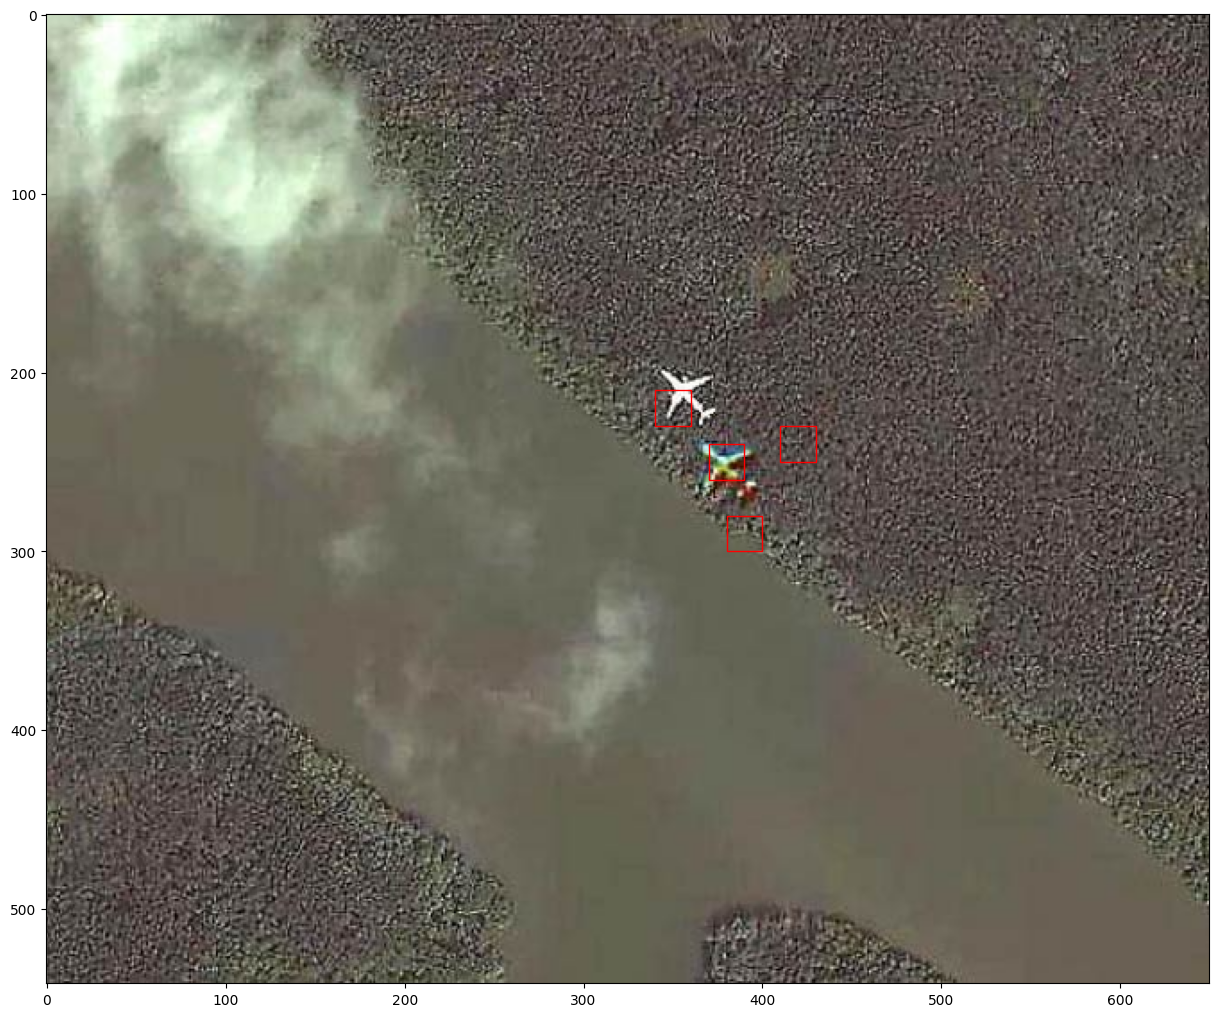

: 

In [32]:
# Load and show scene
basepath = "./data/scenes/scenes"

scene_list = glob(os.path.join(basepath, "*5*"))
scene_file = scene_list[0]

img = cv2.imread(scene_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape

plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)

stride = 10
for h in range(0, height-20, stride):
    print("Step", int(h/stride), "of", int((height-20)/stride))
    
    for w in range(0, width-20, stride):  
        img_box = []
        img_box.append(img[h:h+20, w:w+20])
        img_box = np.array(img_box, dtype=np.int64)
        prediction = model.predict(img_box, verbose=False)
        prediction = np.argmax(prediction)
        
        if prediction == 1:
            ax.add_patch(patches.Rectangle((w, h), 20, 20, edgecolor='r', facecolor='none'))
            
plt.show()